# PHYS20762 - Project - Numerical Integration of a Mass Spring System

George Champion - 10824491 <br>
University of Manchester  
March 2023

In [1]:
# Initialisation
import numpy as np
import matplotlib.pyplot as plt

#constants and initial conditions are defined
m = 3.02
k = 0.55
omega_0 = np.sqrt(k/m)
critical_b = np.sqrt(4*k*m)
b_array = [0, 0.2,critical_b,5]
h_array = [0.2,0.1,0.05,0.01,0.005,0.001]
x_0 = 0
v_0 = -1

## Abstract

This interactive report investigates, via numerical methods, the motion of a mass spring system whose motion is determined by $mx’’(t)+bx’(t)+kx(t) = F(t)$. Where $x(t)$ is the position of the mass, $F(t)$ is the external force and $b$ is the damping coefficient. For this specific example the values of the mass and the spring constant are given by $m = 3.02$ and $k = 0.55$ respectively. The initial conditions set for the analysis were $x_0 = 0$ and $v_0=-1$.

The numerical methods tested are the Euler method, improved Euler method, Euler Cromer method, Verlet method and the 4th order Runge Kutta method. Each method was tested for accuracy against the analytically found solution, the Runge Kutta method was found to be the most accurate.

The Runge Kutta method is then used to analyse the behaviour of a variety of systems such as: when damping is critical; when an instantanious force is applied at different parts of the cycle; when a sinusoidal force is applied to the system and the resonance of the system. The natural frequency of the system was found numerically to be 0.425 ± 0.003 this is within the error of the actual natural frequency which is 0.427.

## Introduction

Knowledge of forced oscillation is required across all corners of physics and engineering. It is required to huge structures such as bridges and skyscrapers that can withstand strong winds and earthquakes, whilst also being necissary for understanding the oscillation of atoms within molecules. Using the most accurate whilst least computationally expensive method to model such systems can help provide us with a greater understanding of the universe.

## Analytical Solution

Firstly, analytical solutions of an unforced system can be computed to test the numerical methods against. Depending on the damping coefficient, the equation used to model system is differnt.<br><br>
If the damping coefficeint is less than the critical damping, $x(t)$ is given by:
<p style="text-align: center;">$x(t) = A\cos(\omega t + \phi)exp(-\frac{\gamma t}{2})$,</p>
<br>
If the damping coefficient is greater than the critical damping, $x(t)$ is given by:
<p style="text-align: center;">$x(t) = exp(-\frac{\gamma t}{2})[Aexp(\alpha t) + Bexp(-\alpha t)]$,</p>
<br>
Finally, if the system is critically damped, $x(t)$ is given by:
<p style="text-align: center;">$x(t) = exp(-\frac{\gamma t}{2})(A + Bt)$,</p>

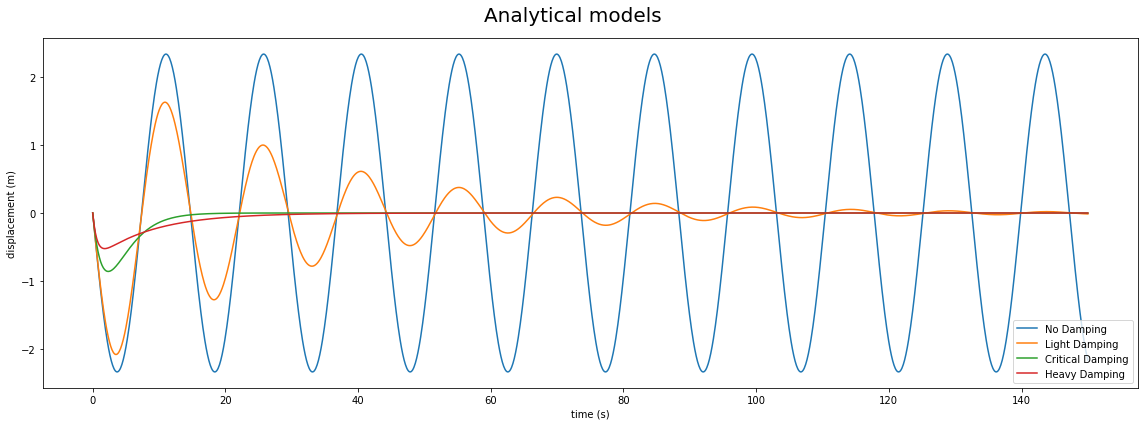

In [2]:
#when finding an analytical solution this function determines which function to use
def analytical_func(b, h, time):
    
    if b < critical_b:
        analytical = light_damping(b, h , time)
        
    elif b > critical_b:
        analytical = heavy_damping(b, h , time)
    else:
        analytical = critical_damping(b, h , time)
        
    return analytical

#Returns the position of a damped harmonic oscillator with light damping.
def light_damping(b, h, time):
    
    # defining coeficients for ease of use in later algebra
    gamma = b/m
    exponent = 1j*np.sqrt(4*k*m-b**2)*time/(2*m)
    A = (b/(2*1j*np.sqrt(4*k*m-b**2)) + 1/2) * x_0 + v_0*m/(np.sqrt(4*k*m - b**2) * 1j)
    B = x_0 - A
    
    #equation of underdamped harmonic oscillation
    x_array = np.exp(-gamma*time/2)*(A*np.exp(exponent) + B*np.exp(-exponent))
    return x_array.real

#Returns the position of a damped harmonic oscillator with heavy damping.
def heavy_damping(b, h, time):
    
    # defining coeficients for ease of use in later algebra
    gamma = b/m
    r_plus = (1/2) * (-gamma+np.sqrt(gamma**2 - 4*k/m))
    r_minus = (1/2) * (-gamma-np.sqrt(gamma**2 - 4*k/m))
    A = x_0 - ((r_minus*x_0 - v_0)/(r_minus - r_plus))
    B = (r_minus*x_0 - v_0)/(r_minus - r_plus)
    
    #equation of overdamped harmonic oscillation
    x_array = A*np.exp(r_minus*time) + B*np.exp(r_plus*time)
    return x_array.real

#Returns the position of a damped harmonic oscillator with critical damping.
def critical_damping(b, h, time):
    
     # defining coeficients for ease of use in later algebra
    gamma = b/m
    #equation of critically damped harmonic oscillation
    x_array = np.exp(-gamma*time/2)*(x_0 + (v_0 + gamma*x_0/2) * time)
    return x_array.real

#Defines constents and sets up arrays
def initialisation(T, h, b):
    nsteps = round(T/h)
    time = np.linspace(0, T, nsteps)
    
    return T, h, b, nsteps, time

T, h, b, nsteps, time = initialisation(150, 0.1, 0)

#Sets up position and velocity arrays
def x_v_initialisation(nsteps):
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = 0
    v[0] = -1
    return x,v

#using the functions to generate arrays
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))
title_array = ["No Damping", "Light Damping", "Critical Damping", "Heavy Damping"]

for i in range(len(title_array)):
    x = analytical_func(b_array[i], h, time)
    ax1.plot(time, x, label = title_array[i])

#plotting the functions
ax1.set_xlabel("time (s)")
ax1.set_ylabel("displacement (m)")
ax1.legend()
fig.suptitle('Analytical models', fontsize=20)
plt.tight_layout()
plt.show()

## Testing numerical methods

In this section we will look at each of the numerical methods in turn and test how well they fit against the analitically found solution. The accuracy of each method will be tested by comparing the energy of the system found numerically to that found analytically. To achieve this some functions determining the position, veloctity, energy and error on energy need to be defined.

In [3]:
#Determines the energy of a using the numerically found arrays
def find_energy(x, v):
    E = np.zeros(len(x))
    E = 1/2 * m * v**2 + 1/2 * k * x**2
    return E

#Determines the energy of the system analytically
def analytical_energy_func(b, time):
    
    #Determines the initial energy
    E_0 = 1/2 * m * v_0**2 + 1/2 * k * x_0**2
    
    #Models the energy analytically
    E = E_0*np.exp(-(b/m)*time)
    
    return E

#Determines the mean energy error
def energy_error_func(analytical, numerical, h):
    return np.mean(np.abs(analytical - numerical)/analytical * 100)

#Determines the values for position, velocity and energy and plots values
def numerical_method(func, name):
    
    #initialising constants to use for first set of plots
    T, h, b, nsteps, time = initialisation(60, 0.1, 0)
    fig, axs = plt.subplots(1,4, figsize=(16, 6))
    fig.suptitle('{} method modelling position of differently damped systems'.format(name), fontsize=20)

    #calculating and plots graphs for the four types of damping
    for i, b in enumerate(b_array):
        analytical = analytical_func(b, h, time)
        x, v = func(h, nsteps, b)
        axs[i].plot(time, x, label = name)
        axs[i].plot(time, analytical, linestyle = "dashed" , label = "Analytical", color = "black")
        axs[i].set_xlabel("time (s)")
        axs[i].set_ylabel("displacement (m)")
        axs[i].set_title(title_array[i])

    #finalizes and displays plots
    plt.legend()
    plt.tight_layout()
    plt.show()

    #initialising constants to use for second set of plots
    fig, axs = plt.subplots(1,1, figsize=(16, 6))
    
    #initialises array of error for different time steps
    energy_error_array = []

    T, h, b, nsteps, time = initialisation(60, 0.1, 0)

    #iterates over h determining the energy and energy error of the method for all h values
    for i, h in enumerate(h_array):
        nsteps = round(T/h)
        time = np.linspace(0, T, nsteps)
        analytical_energy = analytical_energy_func(b, time)
        x, v = func(h, nsteps, b)
        energy = find_energy(x, v)
        energy_error = energy_error_func(analytical_energy, energy, h)
        energy_error_array.append(energy_error)
        axs.plot(time, energy, label = ("h = {:.2}".format(h)))

    #plots found values, formats and displays plots
    axs.plot(time, analytical_energy, linestyle = "dashed" , label = "Analytical", color = "black")
    axs.set_xlabel("time (s)")
    axs.set_ylabel("energy (J)")
    axs.set_title("Energy against time at differnt time steps")
    axs.legend()
    plt.tight_layout()
    plt.show()
    
    return energy_error_array

## Eulers Methed

Eulers method is a first order method of numerical integration, it finds the next position by calculating the velocity at the current point in time and then adding the distance travelled over the time step at that velocity. 

This is defined algebreaically as:
<p style="text-align: center;">$x_{i+1} = x_i + h_i$ </p>
To determine the next term $v_{i+1}$ is found using:
<p style="text-align: center;">$v_{i+1} = v_i + ha_i$ </p>
and $a_i$ is found using:
<p style="text-align: center;">$a_i = -\frac{k}{m} x_i - \frac{b}{m} v_i$ </p>

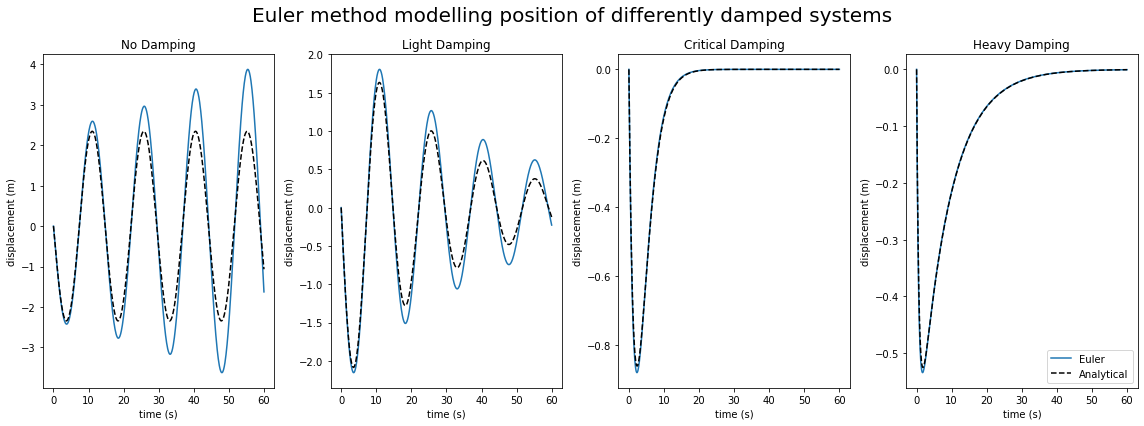

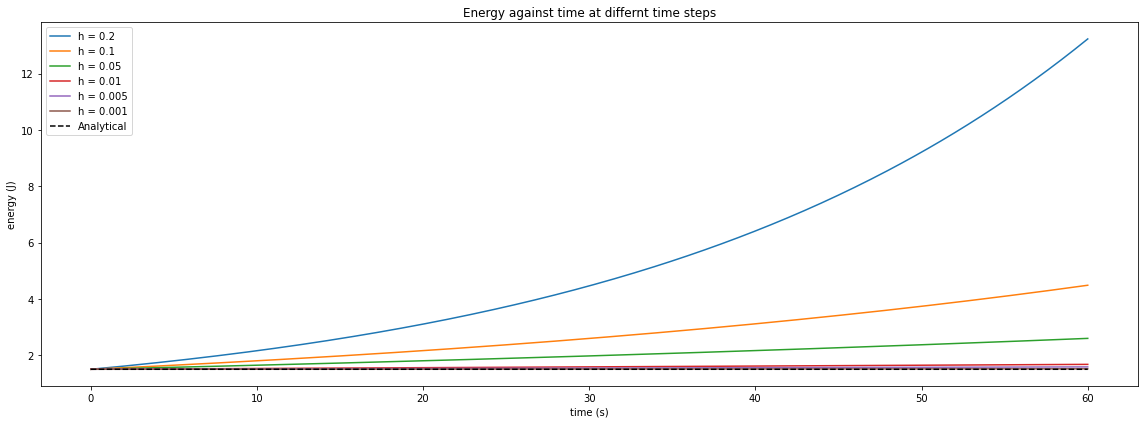

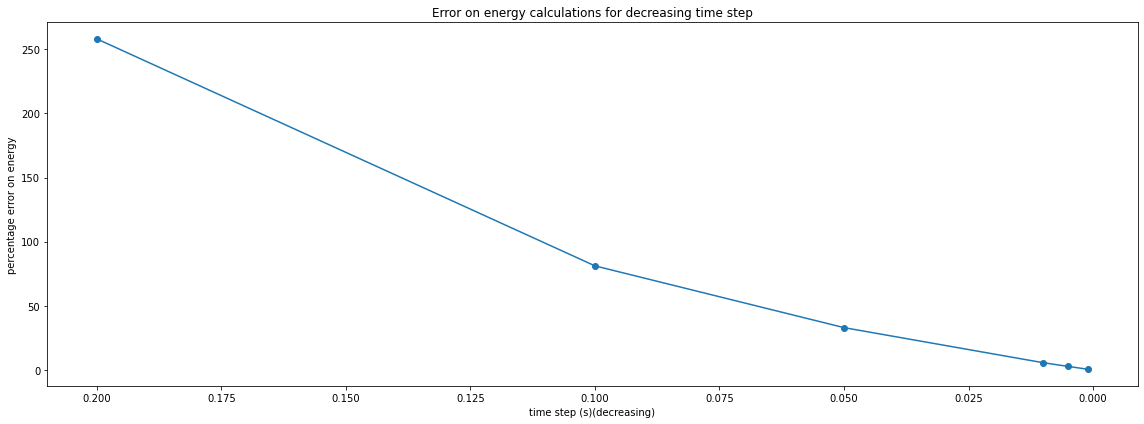

Lowest error value found: 0.548%


In [4]:
#Models a mass spring system using the euler method
def euler_func(h, nsteps, b):
    
    #initialisation of arrays
    x, v = x_v_initialisation(nsteps)
                    
    #iterative process
    for i in range (nsteps-1):
        a = -(k/m)*x[i] - (b/m)*v[i]
        x[i+1] = x[i] + h*v[i]
        v[i+1] = v[i] + h*a
                    
    return x, v

#numerical method is passes to the modelling and plotting function
euler_error = numerical_method(euler_func, "Euler")

#creates plot of the error as time step changes
fig, axs = plt.subplots(1,1, figsize=(16, 6))
axs.invert_xaxis()
axs.set_xlabel("time step (s)(decreasing)")
axs.set_ylabel("percentage error on energy")
axs.set_title("Error on energy calculations for decreasing time step")
axs.plot(h_array, euler_error, 'o-')
plt.tight_layout()
plt.show()

print("Lowest error value found: {:.3}%".format(min(euler_error)))

When the time step is reduced to a small enough value the Euler method is able to model the energy to an error of around 0.5%. When observing the energy against time graph it is apparent that the energy is being overestimated. This overestimation of energy can also be found when analysing the method algebraically:

The energy of the next step can be found using:
<p style="text-align: center;">$E_{i+1} = \frac{1}{2}kx_{i+1}^2 + \frac{1}{2}mv_{i+1}^2 = \frac{1}{2}kx_i^2 + \frac{1}{2}mv_i^2 + \frac{h^2k^2x_i^2}{2m} + \frac{1}{2}h^2kv_i^2$ </p>
When simplified this is:
<p style="text-align: center;">$E_{i+1} = E_i(1+\frac{k}{m}h^2)$. </p>

Which confirms the numerically found increase in energy.


## Improved Euler Method

The improved Euler method is a second order numerical method. It calculates the next position of the mass spring system by calculaitng the velocity and acceleration at the current time step. This accommodates for the fact that the velocity will change over the period between the time steps which isn't accounted for in the Euler method.

This is defined algebreaically as:
<p style="text-align: center;">$x_{i+1} = x_i + h_i + \frac{h^2}{2}a_i $ </p>
The next velocity $v_{i+1}$ is found in the same way as the Euler method:
<p style="text-align: center;">$v_{i+1} = v_i + ha_i$ </p>
as is the acceleration $a_i$:
<p style="text-align: center;">$a_i = -\frac{k}{m} x_i - \frac{b}{m} v_i$ </p>

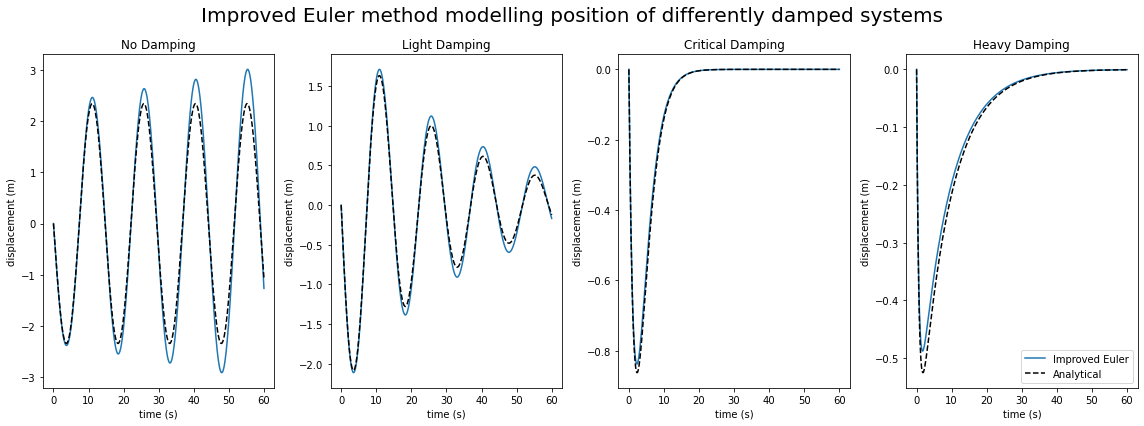

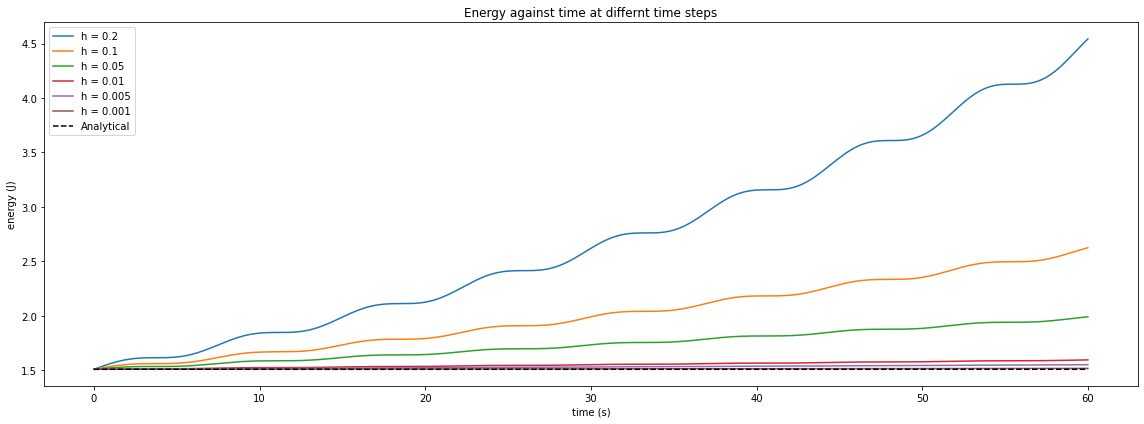

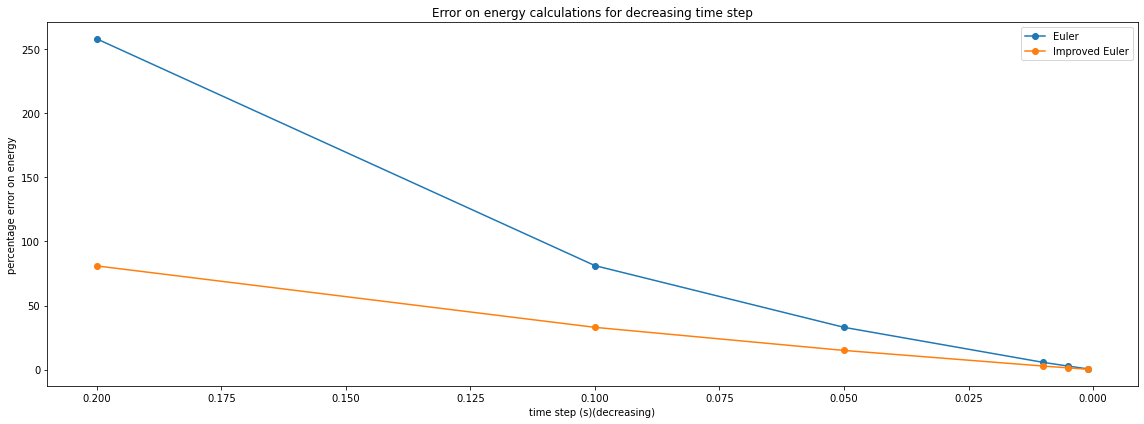

Lowest error value found: 0.274%


In [5]:
#Models a mass spring system using the euler method
def improved_euler_func(h, nsteps, b):
    
    #initialisation of arrays
    x, v = x_v_initialisation(nsteps)

    #iterative process
    for i in range (nsteps-1):
        a = -(k/m)*x[i] - (b/m)*v[i]
        v[i+1] = v[i] + h*a
        x[i+1] = x[i] + h*v[i] + (a*h**2)/2
        
    return x, v

#numerical method is passes to the modelling and plotting function
improved_error = numerical_method(improved_euler_func, "Improved Euler")

#plot of the error as time step changes
fig, axs = plt.subplots(1,1, figsize=(16, 6))
axs.invert_xaxis()
axs.set_xlabel("time step (s)(decreasing)")
axs.set_ylabel("percentage error on energy")
axs.set_title("Error on energy calculations for decreasing time step")
axs.plot(h_array, euler_error, 'o-', label = "Euler")
axs.plot(h_array, improved_error, 'o-', label = 'Improved Euler')
plt.legend()
plt.tight_layout()
plt.show()

print("Lowest error value found: {:.3}%".format(min(improved_error)))

The Improved Euler method did show an improvement in accuracy over the Euler method for underdamped systems especially at higher time step values. However, as seen in the percentage error graph, the two methods appear to be converging towards a similar level of inacuracy as h decreases. This shows the importance of retaining the initial conditions of the system. Whilst the imporved Euler method is more precise, it still holds the same inaccuracies as the euler method as it also is not simplectic.

Strangly the improved Euler method appears to be less accurate at modelling an overdamped system than the euler method. It models the turning point to appear earlier than it should. This means that when approaching the turning point the improved Euler model is overestimating the acceleration that opposes velocity. In this portion of the graph the velocity is decreasing hence the resitive force due to the damping coefficient is decreasing. When the time step is sufficiently large the intricacies of the damping force decreasing are lost resulting in an earlier turning point.

## Euler Cromer method

The Euler Cromer method is a first order method of numerical integration. It is similar to the Euler method, but with one key difference, in the Euler-Cromer method, the velocity is updated using the new position, rather than the old position, before updating the position itself.

The velocity values are found first using:
<p style="text-align: center;">$v_{i+1} = v_i - \frac{hk}{m}x_i$ </p>
Then position values are found 
<p style="text-align: center;">$x_{i+1} = x_i + hv_{i+1}$ </p>


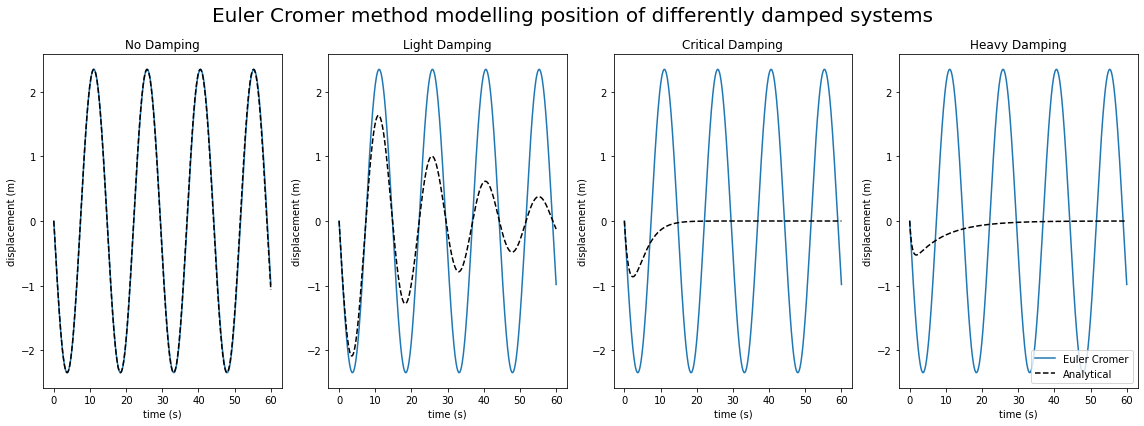

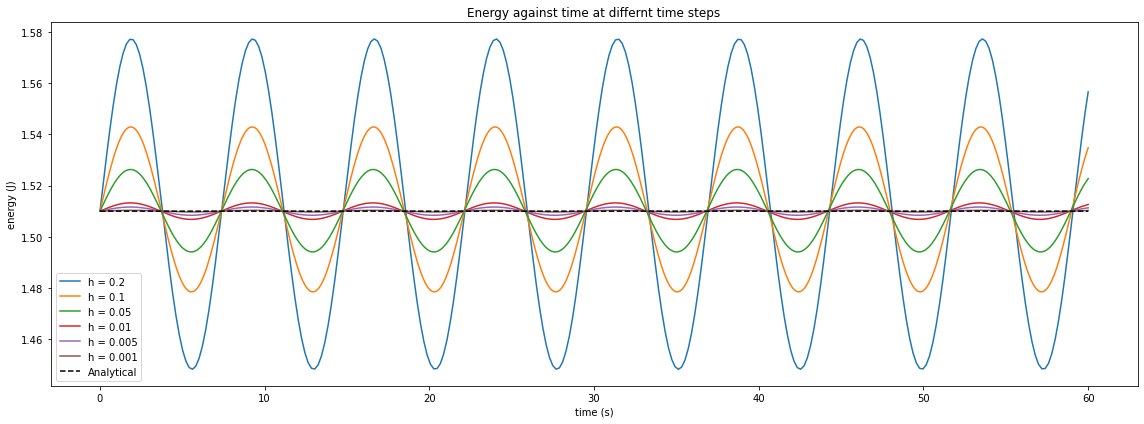

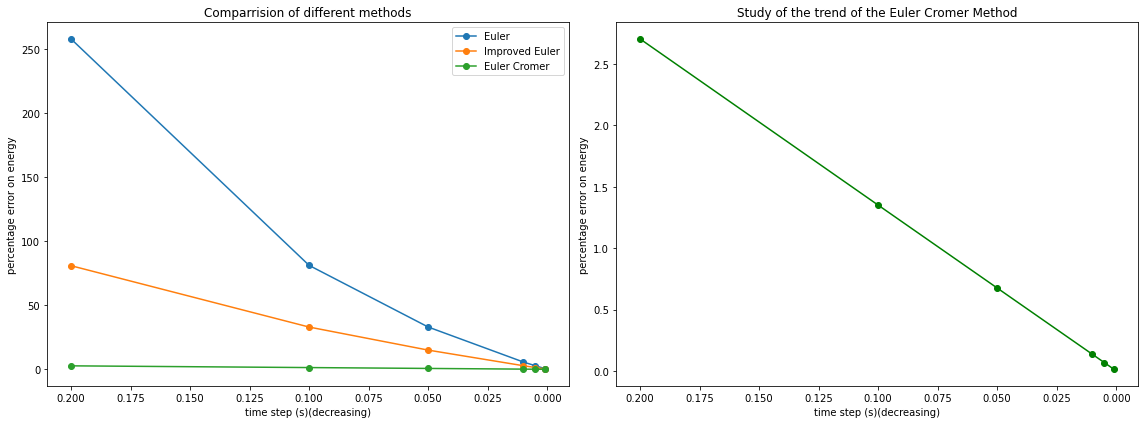

Lowest error value found: 0.0135%


In [6]:
#Models a mass spring system using the Euler Cromer method
def euler_cromer_func(h, nsteps, b):

    #initialisation of arrays
    x, v = x_v_initialisation(nsteps)
    
    # Define function for acceleration
    def acceleration(x, v):
        return -k/m*x

    # Euler-Cromer method
    for i in range(nsteps-1):
        v[i+1] = v[i] + acceleration(x[i], v[i])*h
        x[i+1] = x[i] + v[i+1]*h
        
    return x, v

#numerical method is passes to the modelling and plotting function
cromer_error = numerical_method(euler_cromer_func, "Euler Cromer")

#plot of the error as time step changes
fig, axs = plt.subplots(1,2, figsize=(16, 6))
axs[0].invert_xaxis()
axs[0].set_xlabel("time step (s)(decreasing)")
axs[0].set_ylabel("percentage error on energy")
axs[0].set_title("Comparrision of different methods")
axs[1].invert_xaxis()
axs[1].set_xlabel("time step (s)(decreasing)")
axs[1].set_ylabel("percentage error on energy")
axs[1].set_title("Study of the trend of the Euler Cromer Method")
axs[0].plot(h_array, euler_error, 'o-', label = "Euler")
axs[0].plot(h_array, improved_error, 'o-', label = 'Improved Euler')
axs[0].plot(h_array, cromer_error, 'o-', label = 'Euler Cromer')
axs[1].plot(h_array, cromer_error, 'o-', label = 'Euler Cromer', color = "green")
axs[0].legend()
plt.tight_layout()
plt.show()

print("Lowest error value found: {:.3}%".format(min(cromer_error)))

The Euler Cromer method is far more accurate at modelling an undamped system than the two previoud methods. However, it is energy preserving so is not capable of modelling damped systems. This can be seen as it is inaccurate at modelling the position of the lightly damped, critically damped and heavily damped systems.

It is possible to observe how the Euler Cromer method preserves energy by observing the energy against time graph. Here the oscillations in energy are apparent. For smaller time step values these oscillations are smaller, therefore the avarage error is smaller.

## Verlet Method

The verlet method is a second order numerical method and is the first method used that strays away from the principles of the Euler method. Where the Euler method uses forewards facing difference approximations, Verlets method is based on a centred derivitive.

It is defined by the equtions:<br>
<p style="text-align: center;">$x_{i+1} = 2x_i - x_{i-1} + h^2a_i$ </p>

<p style="text-align: center;">$a_i = -\frac{k}{m}x_i - \frac{b}{m}v_i$ </p>

<p style="text-align: center;">$v_i = \frac{x_{i+1} - x_{i-1}}{2h}$ </p>

Which can be simplified to:
<p style="text-align: center;">$x_{i+1} = Ax_i + Bx_{i-1}$ </p>
Where A and B are defined by:<br>
<p style="text-align: center;">$A = \frac{2m -kh^2}{2m + bh}$ and $B = \frac{bh - 2m}{2m + bh}$ </p>

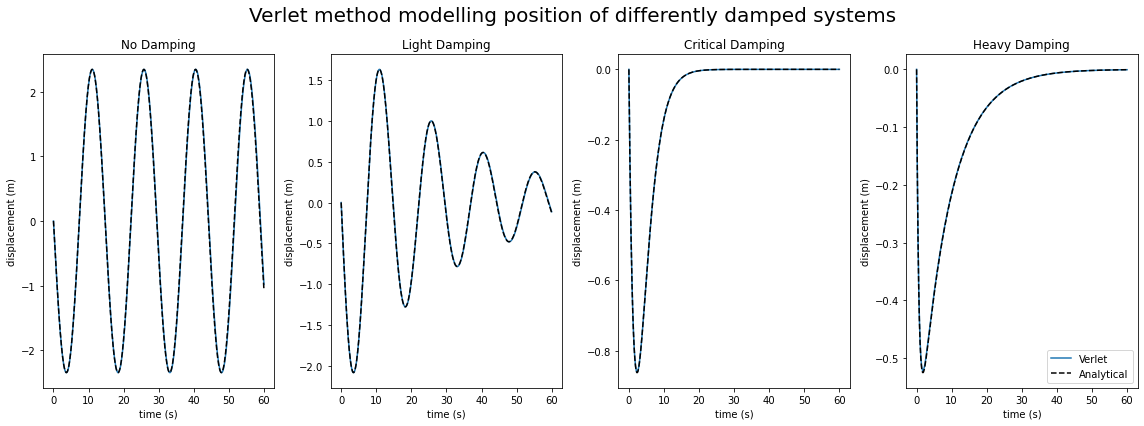

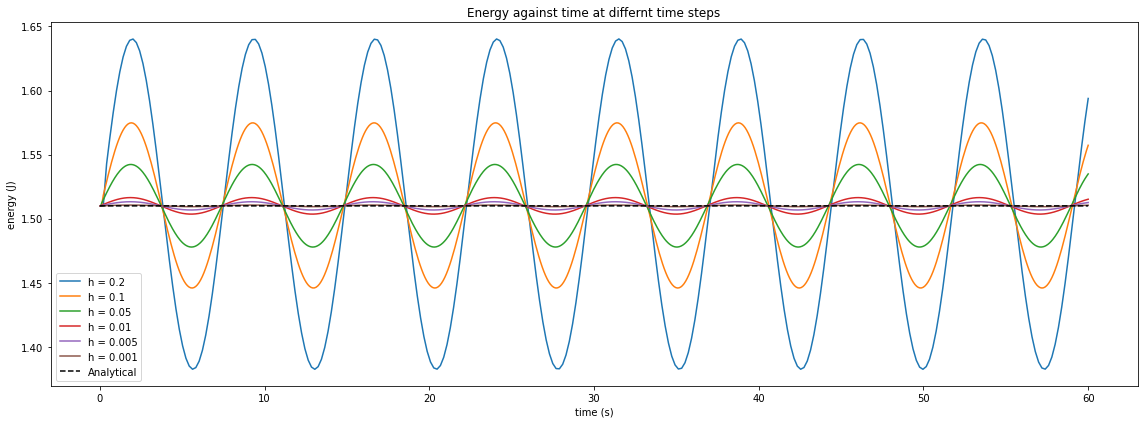

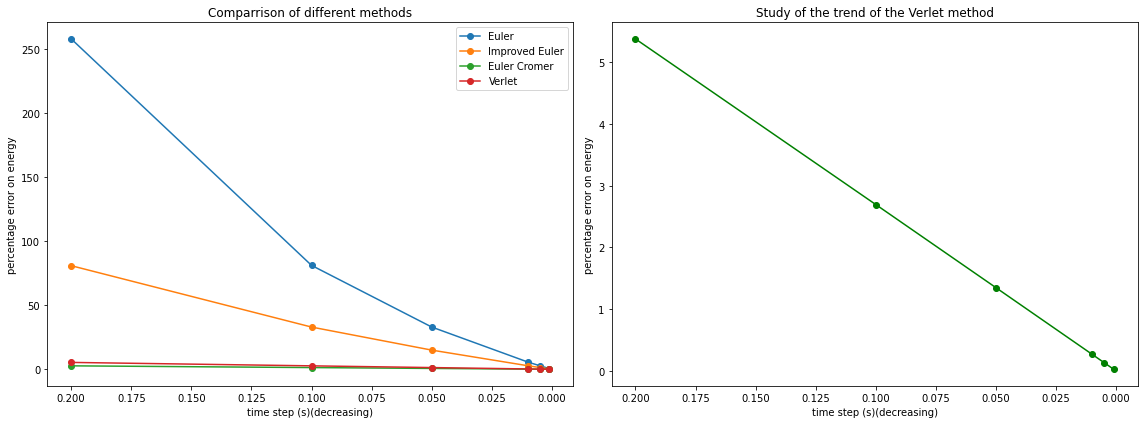

Lowest error value found: 0.027%


In [19]:
#Models a mass spring system using the Verlet method
def verlet_func(h, nsteps, b):
    
    #initialisation of arrays
    x, v = x_v_initialisation(nsteps)
    
    #Defines coefficietns for ease of use in algebra
    D = 2*m + b*h
    A = 2*((2*m-k*h**2)/D)
    B = (b*h - 2*m)/D
    
    #uses the Improved Euler method for the first iteration
    a_0 = -(k/m)*x[0] - (b/m)*v[0]
    x[1] = x[0] + h*v[0] + (a_0*h**2)/2
    v[1] = v[0] + (h/2)*(a_0 + -(k/m)*x[1] - (b/m)*v[0])
    
    #iterative process
    for i in range (1, nsteps-1):
        x[i+1] = A*x[i] + B*x[i-1]
        v[i+1] = (x[i+1]-x[i-1])/(2*h)
        
    return x, v

#numerical method is passes to the modelling and plotting function
verlet_error = numerical_method(verlet_func, "Verlet")

#plot of the error as time step changes
fig, axs = plt.subplots(1,2, figsize=(16, 6))
axs[0].invert_xaxis()
axs[0].set_xlabel("time step (s)(decreasing)")
axs[0].set_ylabel("percentage error on energy")
axs[0].set_title("Comparrison of different methods")
axs[1].invert_xaxis()
axs[1].set_xlabel("time step (s)(decreasing)")
axs[1].set_ylabel("percentage error on energy")
axs[1].set_title("Study of the trend of the Verlet method")
axs[0].plot(h_array, euler_error, 'o-', label = "Euler")
axs[0].plot(h_array, improved_error, 'o-', label = 'Improved Euler')
axs[0].plot(h_array, cromer_error, 'o-', label = 'Euler Cromer')
axs[0].plot(h_array, verlet_error, 'o-', label = 'Verlet')
axs[1].plot(h_array, verlet_error, 'o-', label = 'Verlet', color = "green")
axs[0].legend()
plt.tight_layout()
plt.show()

print("Lowest error value found: {:.3}%".format(min(verlet_error)))

The Verlet method was found to be more accurate than both the Euler and improved Euler method. It shares the feature of the energy avaraging out to be accurate over a half cycle with the Euler Cromer method. 

Similarly to the Euler Cromer method, its energy is found to be accurate when avaraging over a half cycle. As well as this, when the time step is decreased the fluctuations in energy decrease which can also be observed in the Euler Cromer method

## 4th Order Kunge Kutta Method

The 4th order Runge Kutta method operates at a higher level of accuracy than the other methods used as it a fourth order method. The method involves evaluating four intermediate slopes at different points within a time step, using a weighted average of these slopes to calculate the new values of x and v at the end of the time step. It is not simplectic.

The aproximaition of the fist intermediate slope is outlined below as well as the process used to average the values:

<p style="text-align: center;">$k1_x = hv_{i-1}$ </p>
<p style="text-align: center;">$k1_v = h(-\frac{kx_{i-1}}{m} - \frac{-bv_{i-1}}{m})$ </p>

They are then averaged using:
<p style="text-align: center;">$x_i = x_{i-1} + \frac{k1_x + 2k2_x + 2k3_x + k4_x}{6}$ </p>
<p style="text-align: center;">$v_i = v_{i-1} + \frac{k1_v + 2k2_v + 2k3_v + k4_v}{6}$ </p>

It should be more accurate than previous methods used but also far more computationally expensive.

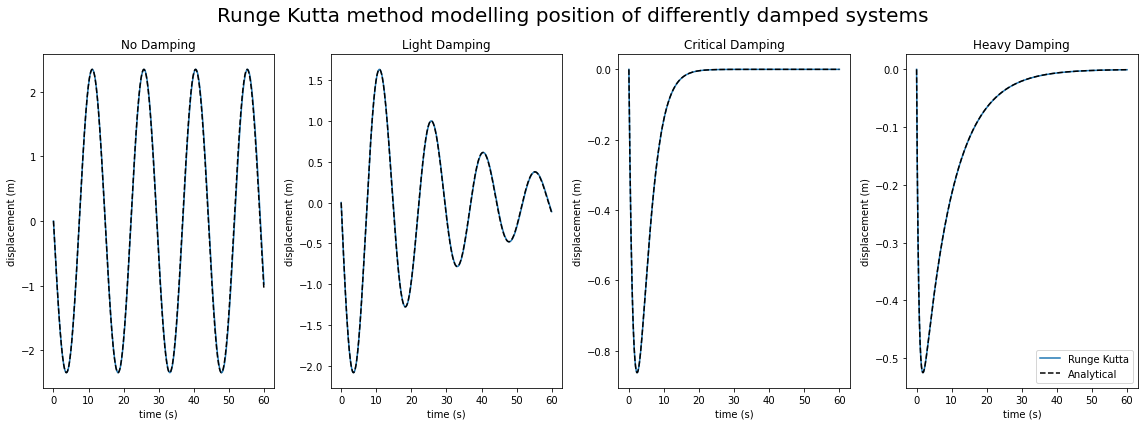

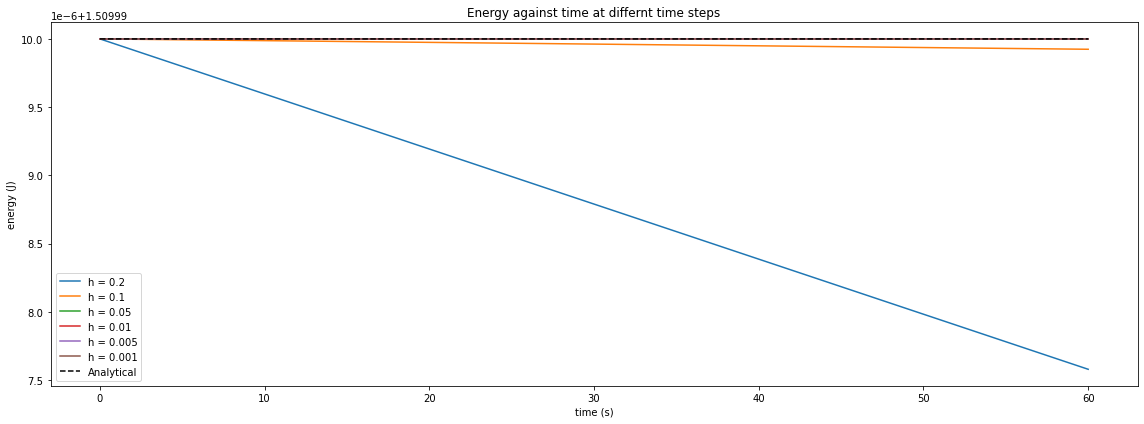

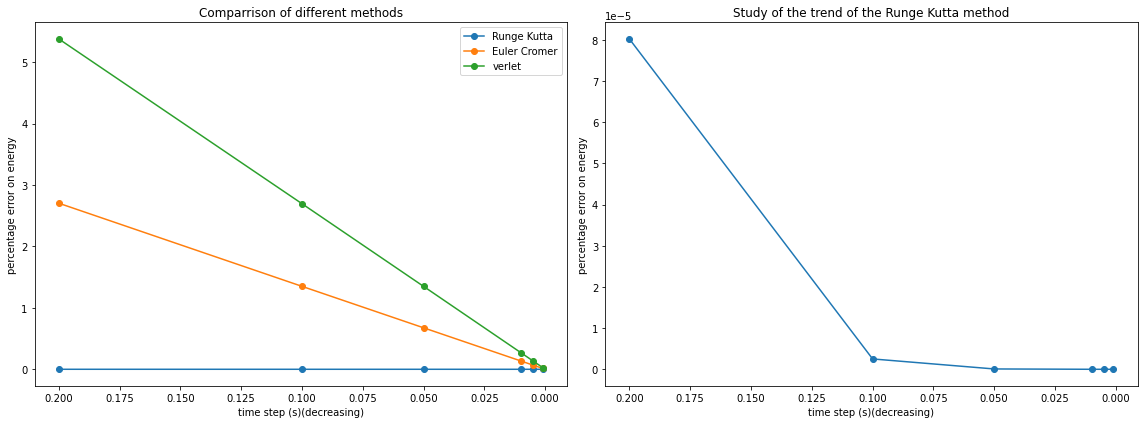

Lowest error value found: 8.03e-13%


In [18]:
#Models a mass spring system using the fourth order u method
def runge_kutta_func(h, nsteps, b):
    
    #initialisation of arrays
    x, v = x_v_initialisation(nsteps)

    #defines acceleration
    def a(t, x, v):
        return (-k * x - b * v) / m

    #iterative process
    for i in range(1, nsteps):
        t = T + i * h
        k1_x = h * (v[i - 1])
        k1_v = h * a(t, x[i - 1], v[i - 1])
        k2_x = h * (v[i - 1] + k1_v / 2)
        k2_v = h * a(t + h / 2, x[i - 1] + k1_x / 2, v[i - 1] + k1_v / 2)
        k3_x = h * (v[i - 1] + k2_v / 2)
        k3_v = h * a(t + h / 2, x[i - 1] + k2_x / 2, v[i - 1] + k2_v / 2)
        k4_x = h * (v[i - 1] + k3_v)
        k4_v = h * a(t + h, x[i - 1] + k3_x, v[i - 1] + k3_v)
        x[i] = x[i - 1] + (k1_x + 2 * k2_x + 2 * k3_x + k4_x) / 6
        v[i] = v[i - 1] + (k1_v + 2 * k2_v + 2 * k3_v + k4_v) / 6

    return x, v

#numerical method is passes to the modelling and plotting function
runge_kutta_error = numerical_method(runge_kutta_func, "Runge Kutta")

#plot of the error as time step changes
fig, axs = plt.subplots(1,2, figsize=(16, 6))
axs[0].invert_xaxis()
axs[0].set_xlabel("time step (s)(decreasing)")
axs[0].set_ylabel("percentage error on energy")
axs[0].set_title("Comparrison of different methods")
axs[1].invert_xaxis()
axs[1].set_xlabel("time step (s)(decreasing)")
axs[1].set_ylabel("percentage error on energy")
axs[1].set_title("Study of the trend of the Runge Kutta method")
axs[0].plot(h_array, runge_kutta_error, 'o-', label = 'Runge Kutta')
axs[0].plot(h_array, cromer_error, 'o-', label = 'Euler Cromer')
axs[0].plot(h_array, verlet_error, 'o-', label = 'verlet')
axs[1].plot(h_array, runge_kutta_error, 'o-', label = 'Runge Kutta')
axs[0].legend()
plt.tight_layout()
plt.show()

print("Lowest error value found: {:.3}%".format(min(runge_kutta_error)))

The 4th order Runge Kutta mathod is far more accurate than either of the other non simplectic algorithms. Unlike the Euler and improved Euler systems the Runge Kutta method models the system to lose energy as opposed to gain energy. However as demostrated by the scale of the y axis of the energy time graph the reduction in energy is not significant.

Ontop of this, it is also more accurate than the two simplectic algorithms at the h values tested. As the time step decreases the error of the simplectic algorithms decreases at a greater rate to that of the runge kutta so for a sufficient number of time steps simplectic algorithms would be the prefered method. However for the h values that are viable so as to not take up too much computing power the Runge Kutta is far superior.

## Finding the best time step for the Runge Kutta Method

The error on energy of the Runge Kutta method will now be looked at in more detail to determine the bets time step value and the trend. Time step values between 0.1 and 1 will be observed.

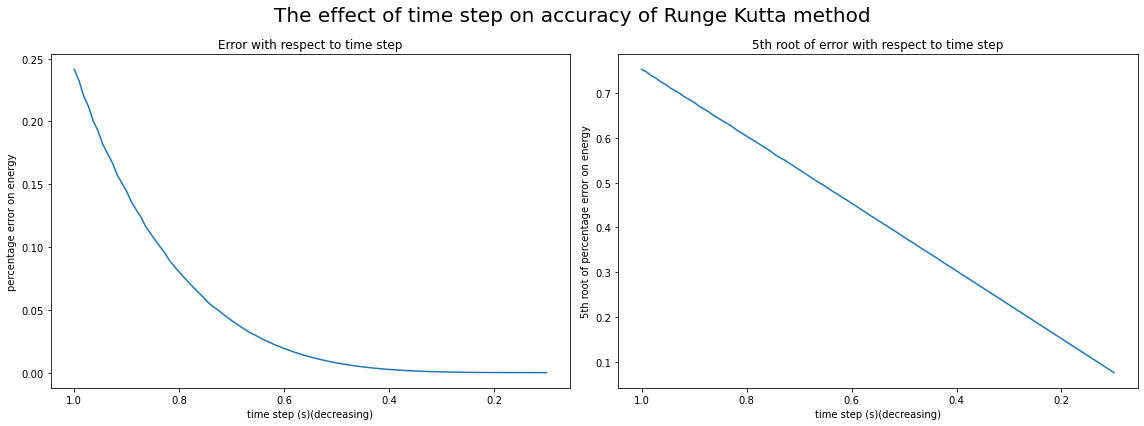

Lowest error value found: 2.51e-06% when h = 0.1


In [17]:
#initialising constants to use for second set of plots
fig, axs = plt.subplots(1,2, figsize=(16, 6))
fig.suptitle('The effect of time step on accuracy of Runge Kutta method', fontsize=20)
T, h, b, nsteps, time = initialisation(60, 0.1, 0)
runge_kutta_error = np.empty(0)
testing_h_values = np.linspace(0.1,1,100)

#iterates over h determining the energy and energy error of the method for all h values
for i, h in enumerate(testing_h_values):
    nsteps = round(T/h)
    time = np.linspace(0, T, nsteps)
    analytical_energy = analytical_energy_func(b, time)
    x, v = runge_kutta_func(h, nsteps, b)
    energy = find_energy(x, v)
    error = energy_error_func(analytical_energy, energy, h)
    runge_kutta_error = np.append(runge_kutta_error,error)

#determines the 5th root of the error values
fifth_root_arr = runge_kutta_error ** (1/5)

#plots found values and formats plots
axs[0].invert_xaxis()
axs[0].set_xlabel("time step (s)(decreasing)")
axs[0].set_ylabel("percentage error on energy")
axs[0].plot(testing_h_values, runge_kutta_error)
axs[0].set_title("Error with respect to time step")
axs[1].plot(testing_h_values,fifth_root_arr)
axs[1].invert_xaxis()
axs[1].set_xlabel("time step (s)(decreasing)")
axs[1].set_ylabel("5th root of percentage error on energy")
axs[1].set_title("5th root of error with respect to time step")
plt.tight_layout()
plt.show()

best_h_index = np.argmin(runge_kutta_error)

print("Lowest error value found: {:.3}% when h = {:.3}".format((min(runge_kutta_error)), testing_h_values[best_h_index]))

As seen in the graph, the error only gets smaller as h decreases. The error decreases linearly with the 5th power of the time step. This makes sense as the Runge Kutta method is of the 4th order. This shows that the increase in accuracy drops off very quickly as the time step decreases. Hence a time step of $h = 0.1$ will be used as it isn't computationally demanding whilst still being far more accurate than the other methods.

## Noteworthy damping coefficients

In this section we will observe how position and energy change when the damping coeficient is euqel to, half of and double the critical damping.

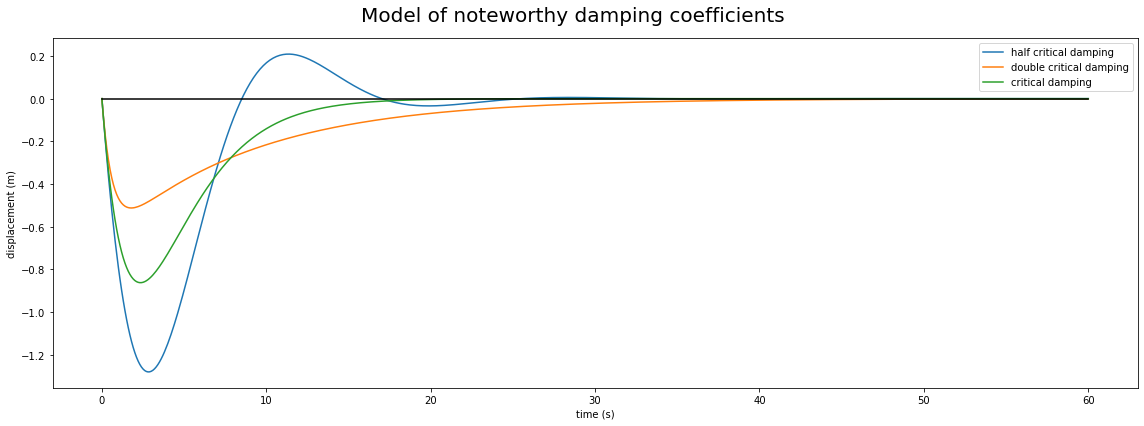

In [16]:
#setting h and other values or arrays that depend on h
T, h, b, nsteps, time = initialisation(60, 0.1, 0)

#Creates an arrya of damping values to use
critical_b_array = [critical_b/2, 2*critical_b, critical_b]

#Initialises plot
fig, axs = plt.subplots(1,1, figsize=(16, 6))
fig.suptitle('Model of noteworthy damping coefficients', fontsize=20)

#Iterates through the b values and plots them
for b in critical_b_array:
    runge_kutta_x, runge_kutta_v = runge_kutta_func(h, nsteps, b)
    axs.plot(time, runge_kutta_x)
    axs.legend(['half critical damping', 'double critical damping', 'critical damping'])

#
x_axis = np.zeros(len(time))
axs.plot(time, x_axis, color = "black")
axs.set_ylabel("displacement (m)")
axs.set_xlabel("time (s)")
plt.tight_layout()
plt.show()
    

#### Underdamping

In an underdamped system the damping coefficient is too small to sufficiently slow down the mass spring system, therefore the mass overshoots the x axis, oscillating before reaching equilibrium.

#### Overdamping

The overdamped system has a damping coefficient that is too large, this means that despite the turning point being earlier, it reaches the x axis after the critically damped system.

#### Critical damping

The critically damped system has a damping coefficient that slows down the velocity such that the mass does not overshoot the x axis whilst not slowing it down too much on its way there. It it the fastest way to remove energy from the system.

## Sudden Application of an External Force

In this section we will observe how the mass spring system behaves when an sudden force is applied. The function below is a modified version of the Runge Kutta method that allows for external forces. In this section a light damping coefficient of $b = 0.2$ is used. 

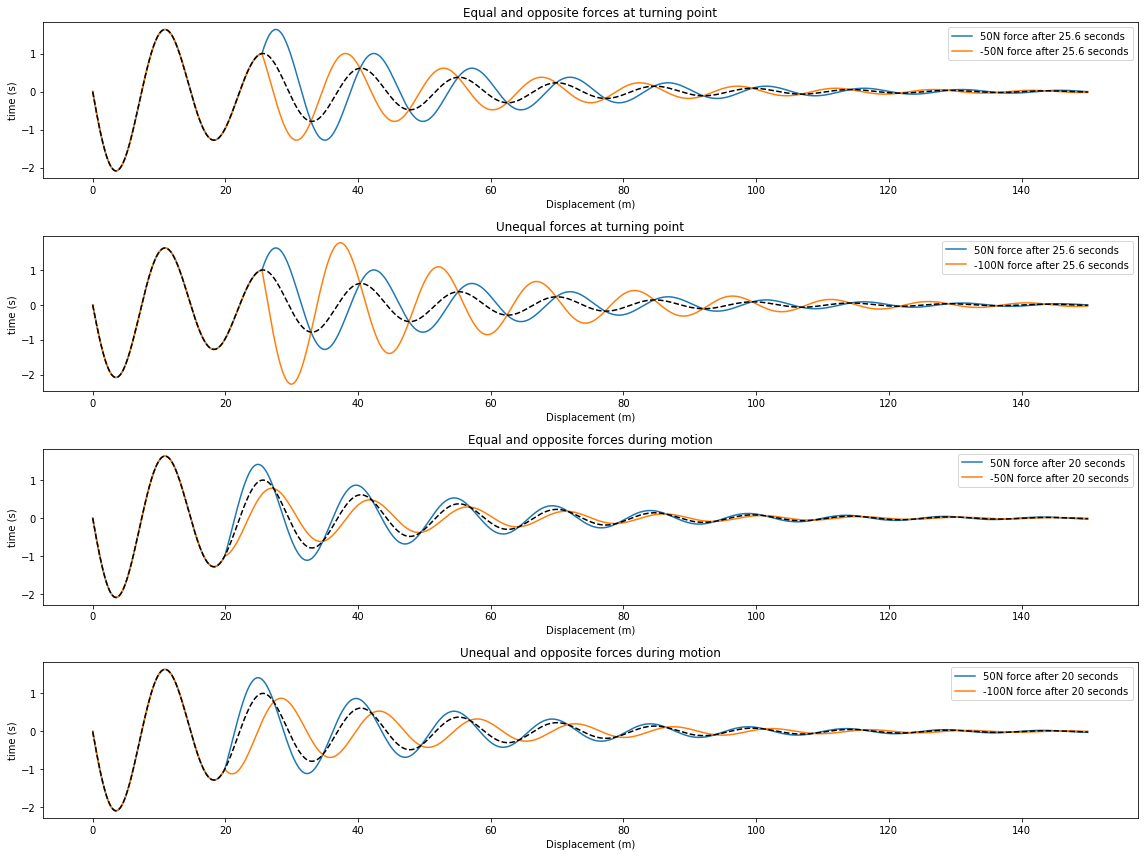

In [15]:
#Modified version of the Runge Kutta function that applies a force at a given time
def forced_rk(h, nsteps, b, external, force_time):
    
    #initialisation of arrays
    x, v = x_v_initialisation(nsteps)

    #acceleration function which allows for force to be applied at specific time
    def a(t, x, v, external, force_time):
        if t == force_time:
            return (-k * x - b * v + external) / m
        return (-k * x - b * v) / m

    #iterative process
    for i in range(1, nsteps):
        t = i * h
        k1_x = h * (v[i - 1])
        k1_v = h * a(t, x[i - 1], v[i - 1], external, force_time)
        k2_x = h * (v[i - 1] + k1_v / 2)
        k2_v = h * a(t + h / 2, x[i - 1] + k1_x / 2, v[i - 1] + k1_v / 2, external, force_time)
        k3_x = h * (v[i - 1] + k2_v / 2)
        k3_v = h * a(t + h / 2, x[i - 1] + k2_x / 2, v[i - 1] + k2_v / 2, external, force_time)
        k4_x = h * (v[i - 1] + k3_v)
        k4_v = h * a(t + h, x[i - 1] + k3_x, v[i - 1] + k3_v, external, force_time)
        x[i] = x[i - 1] + (k1_x + 2 * k2_x + 2 * k3_x + k4_x) / 6
        v[i] = v[i - 1] + (k1_v + 2 * k2_v + 2 * k3_v + k4_v) / 6

    return x, v

#Initialises constants and arrays
T, h, b, nsteps, time = initialisation(150, 0.1, 0.2)

#Initialises plot
fig, axs = plt.subplots(4,1, figsize=(16, 12))

#arrays containing the forces and the times they are applies as well as titles for the plots
force_times = [25.6,25.6,20,20]
forces = [[50,-50],[50,-100],[50,-50],[50,-100]]
labels = ['Equal and opposite forces at turning point','Unequal forces at turning point',
         'Equal and opposite forces during motion','Unequal and opposite forces during motion']

#Iterating through differently forced systems, modelling and plotting them
for i, force in enumerate(forces):
    analytical_x = analytical_func(b, h, time)
    x, v = forced_rk(h, nsteps, b, forces[i][0], force_times[i])
    axs[i].plot(time,x, label = "{}N force after {} seconds".format(forces[i][0], force_times[i]))
    x, v = forced_rk(h, nsteps, b, forces[i][1], force_times[i])
    axs[i].plot(time,x, label = "{}N force after {} seconds".format(forces[i][1], force_times[i]))
    axs[i].set_title(labels[i])
    axs[i].set_xlabel("Displacement (m)")
    axs[i].set_ylabel("time (s)")
    axs[i].plot(time, analytical_x, color = "black", linestyle = "dashed")
    axs[i].legend()

plt.tight_layout()    
plt.show()

As seen in the above plots, when the sudden force is applied when the block is at a turning point the phase shift is equal and opposite regardless of the direction and magnitude of the force. When the forces are the same magnitude the amplitude of the peaks are also equal.

This is not the case when the force is applied during the motion of the block. Instead, force that opposes motion causes a greater shift in phase. 

## Sinusoidal forcing of mass spring system

In this section we will examine the effects of applying a sinusoidal force to the system. We will model cases when the frequency of the force is greater than and less than the natural frequency of the system. 

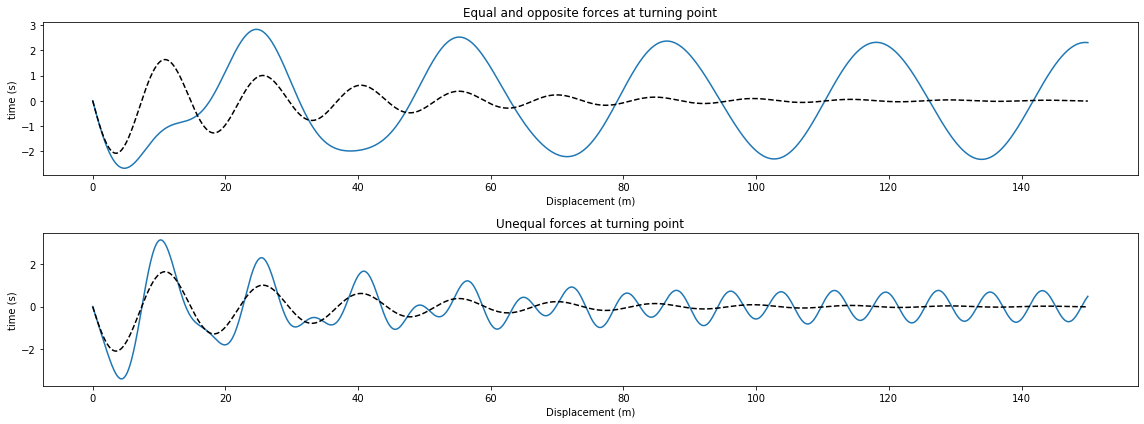

In [14]:
#generates a sin function of given amplitude, frequency and length
def generate_sin(A, frequency, time):
    return -A * np.sin(frequency*time)

#Modified Runge Kutta function that allows for a sinusoidal force to be applied
def forced_rk_sin(h, nsteps, b, sin):
    
    #initialisation of arrays
    x, v = x_v_initialisation(nsteps)

    #modified acceleration function that applies a sinusoidal force to the mass
    def a(t, x, v, sin):
        return (-k * x - b * v + sin) / m

    #iterative process
    for i in range(1, nsteps):
        t = i * h
        k1_x = h * (v[i - 1])
        k1_v = h * a(t, x[i - 1], v[i - 1], sin[i])
        k2_x = h * (v[i - 1] + k1_v / 2)
        k2_v = h * a(t + h / 2, x[i - 1] + k1_x / 2, v[i - 1] + k1_v / 2, sin[i])
        k3_x = h * (v[i - 1] + k2_v / 2)
        k3_v = h * a(t + h / 2, x[i - 1] + k2_x / 2, v[i - 1] + k2_v / 2, sin[i])
        k4_x = h * (v[i - 1] + k3_v)
        k4_v = h * a(t + h, x[i - 1] + k3_x, v[i - 1] + k3_v, sin[i])
        x[i] = x[i - 1] + (k1_x + 2 * k2_x + 2 * k3_x + k4_x) / 6
        v[i] = v[i - 1] + (k1_v + 2 * k2_v + 2 * k3_v + k4_v) / 6

    return x, v

#array of frequencies tested
frequencies = [0.2,0.8]

#Initialises figure
fig, axs = plt.subplots(2,1, figsize=(16, 6))

#Iterates over the array of frequencies modelling and plotting the functions
for i,f in enumerate(frequencies):
    analytical_x = analytical_func(b, h, time)
    x, v = forced_rk_sin(h, nsteps, b, generate_sin(1, f, time))
    axs[i].plot(time,x)
    axs[i].set_title(labels[i])
    axs[i].set_xlabel("Displacement (m)")
    axs[i].set_ylabel("time (s)")
    axs[i].plot(time, analytical_x, color = "black", linestyle = "dashed")
    
plt.tight_layout()
plt.show()

The plots show an initial transient period as the frequency of the system changes from its natural frequency to the forced frequency.

## Testing resonant frequencies

In this section we will investigate the resonance of a system with frequencies either side of the natural frequency, the amplitude of this system will then be plotted as a function of frequency. 

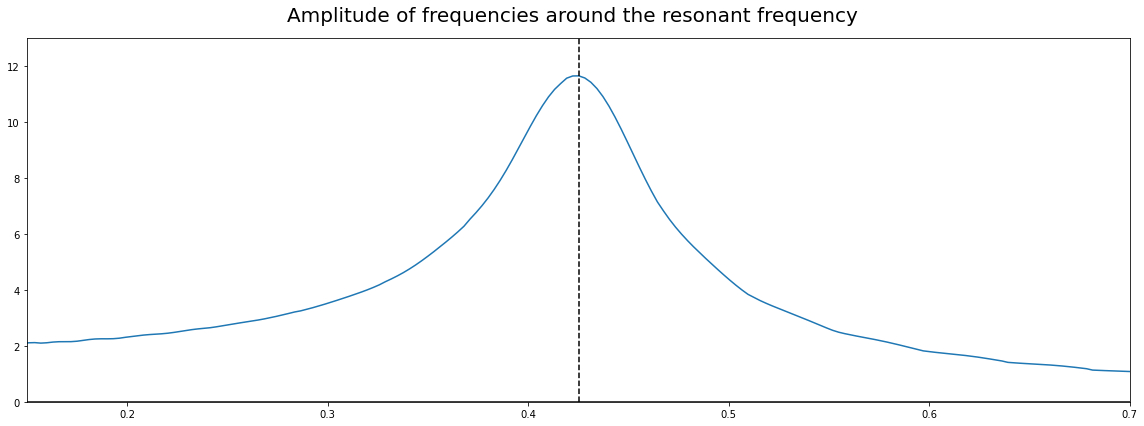

The natural frequency of the system was found to be 0.425 ± 0.003
The actual natural frequency is 0.427


In [13]:
#return the amplitude of the final maxima that is plotted as this is the least likely to be
#effected by the transience
def find_amplitude(position):
    
    local_maxima = []
    #iterates through the position values adding each local maxima to an array
    for i in range(1, len(position) - 1):
        if position[i] > position[i-1] and position[i] > position[i+1]:
            local_maxima.append(position[i])

    #returns the final local maxima
    return local_maxima[-1]
        
#Initialises array of frequencies tested and creates an empty array to store the amplitudes
frequencies = np.linspace(omega_0 - 0.3, omega_0 + 0.3, 200)
amplitude_array = np.zeros(0)

#Iterates through the frequencies and calculates corresponding amplitudes
for f in frequencies:
    x, v = forced_rk_sin(h, nsteps, b, generate_sin(1, f, time))
    amplitude_array = np.append(amplitude_array, find_amplitude(x))

#finds the natural frequency
natural_frequency = frequencies[np.argmax(amplitude_array)]

#allows for a vertical line through the natural frequency to be plotted
y_array = np.linspace(0,13,10)
straight_line_array = natural_frequency*np.linspace(1,1,10)
x_axis = np.zeros(len(frequencies))

#plots the amplitudes against the frequencies
fig, axs = plt.subplots(1,1, figsize=(16, 6))
fig.suptitle('Amplitude of frequencies around the resonant frequency', fontsize=20)
axs.plot(frequencies, amplitude_array)
axs.plot(straight_line_array, y_array, linestyle = "dashed", color = "black")
axs.plot(frequencies, x_axis, color = "black")
axs.set_ylim(0, 13)
axs.set_xlim(0.15, 0.7)
plt.tight_layout()
plt.show()

#The error on the value is found from the step size of frequencies and is printed
width = 0.6
number_of_points = 200
error = width/number_of_points
print("The natural frequency of the system was found to be {:.3} \u00B1 {}".format(natural_frequency, error))
print("The actual natural frequency is {:.3}".format(omega_0))

The natural frequency of the system has been successfully found within the error, said error is due to the increament that the frequency was increased. There are unexpected rough characteristics at either end of the plot. This is because as the driving frequency strays away from the natural frequency, the time taken for the transient period to end increases. Due to this the amplitude is less accurate at either end of the plot. However, the area around the natural frequency is smooth and accurate.

## Conclusion

The Runge Kutta method far outperformed the other methods due to being a 4th order method. This allowed for the accurate modelling of forced systems and the numerical determination of the natural frequency.